# KAN-ODE

In [170]:
import sys
sys.path.append('/home/sdu123/WORK/KODE')

In [171]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchdiffeq import odeint
import torch.distributions as dists
import pandas as pd
from base_kan.ekan import EKAN 

In [ ]:
class CustomSIRSystem(nn.Module):
    def __init__(self, neural_part, gamma, beta):
        super(CustomSIRSystem, self).__init__()
        self.neural_part = neural_part
        self.gamma = gamma
        self.beta = beta
        self.neural_outputs = [] 

    def forward(self, t, y):
        S, I, R, A = y
        neural_output = self.neural_part(torch.tensor([S, I], dtype=torch.float32).unsqueeze(0)).squeeze()
        self.neural_outputs.append(neural_output.detach().numpy())  
        dR_dt = self.gamma * I
        dI_dt = abs(neural_output) - self.gamma * I
        dS_dt = - abs (neural_output)
        dA_dt = abs (neural_output)
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])

In [ ]:
gamma = 0.007
beta = 2 * gamma  
neural_ode_func = EKAN(layers_hidden=[2, 128, 1])
model = CustomSIRSystem(neural_ode_func, gamma, beta)

In [ ]:
intial = 0.  #
last= 40.    
step = 40   
y0 = torch.tensor([0.99, 0.01, 0.0, 0.0], requires_grad=True)  
t = torch.linspace(intial, last, step)  

In [175]:
def get_data():
    gamma = 0.007
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0, 0.0])
    a=0.2
    def sir(t, y):
        S, I, R, A = y
        dS_dt = -beta * S * I * (10*torch.exp(-a*t)+5)
        dI_dt = beta * S * I * (10*torch.exp(-a*t)+5)- gamma * I
        dR_dt = gamma * I
        dA_dt = beta * S * I * (10*torch.exp(-a*t)+5)
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, true_y = get_data()

In [176]:
def compute_loss(pred_y, true_y):
    return torch.mean((pred_y[:, 3] - true_y[:, 3]) ** 2)

In [177]:
def compute_accuracy(pred_y, true_y, threshold=0.01):
    diff = torch.abs(pred_y[:, 3] - true_y[:, 3])
    correct = (diff < threshold).float().mean()
    return correct.item()

In [ ]:
def forword_CF(x):
   
    x = torch.tensor(x, dtype=torch.float32).clone().detach()
    
    if x.size(0) < 2:
        raise ValueError("Input tensor must have at least 2 elements.")
    
  
    result = x.clone().detach()
    
    
    result[1:] = x[1:] - x[:-1]
    
    return result

In [179]:
def train():
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    for itr in range(3000):
        optimizer.zero_grad()
        pred_y = odeint(model, y0, t, rtol=1e-5, atol=1e-8)
        loss = compute_loss(pred_y, true_y)
        loss.backward()
        optimizer.step()

        if itr % 100 == 0:
            accuracy = compute_accuracy(pred_y, true_y)
            print(f'Iter {itr}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

    return t, true_y, pred_y, model.neural_outputs

In [180]:
t, True_y, pred_y, neural_outputs = train()

Iter 0, Loss: 0.06626635044813156, Accuracy: 2.50%
Iter 100, Loss: 0.0002745153906289488, Accuracy: 32.50%
Iter 200, Loss: 0.000208198995096609, Accuracy: 37.50%
Iter 300, Loss: 0.00014147613546811044, Accuracy: 50.00%
Iter 400, Loss: 8.605176117271185e-05, Accuracy: 70.00%
Iter 500, Loss: 4.686111424234696e-05, Accuracy: 90.00%
Iter 600, Loss: 2.294309888384305e-05, Accuracy: 95.00%
Iter 700, Loss: 1.0217550880042836e-05, Accuracy: 100.00%
Iter 800, Loss: 4.262769834895153e-06, Accuracy: 100.00%
Iter 900, Loss: 1.7851289157988504e-06, Accuracy: 100.00%
Iter 1000, Loss: 8.587567208451219e-07, Accuracy: 100.00%
Iter 1100, Loss: 5.408759307101718e-07, Accuracy: 100.00%
Iter 1200, Loss: 4.3830459617311135e-07, Accuracy: 100.00%
Iter 1300, Loss: 4.052239148677472e-07, Accuracy: 100.00%
Iter 1400, Loss: 3.937128383313393e-07, Accuracy: 100.00%
Iter 1500, Loss: 3.8889257325536164e-07, Accuracy: 100.00%
Iter 1600, Loss: 3.862203357130056e-07, Accuracy: 100.00%
Iter 1700, Loss: 3.8439088712038

In [181]:
True_y[:,3] = forword_CF(True_y[:,3])
pred_y[:,3] = forword_CF(pred_y[:,3])

/tmp/ipykernel_1410129/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [ ]:

extend = 40
timeintial = intial
timeend = last + extend
timestep = step + extend
in_t = torch.linspace(timeintial, timeend, timestep)

In [183]:
def get_data():
    gamma = 0.007
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0, 0.0])
    a=0.2
    def sir(t, y):
        S, I, R, A = y
        dS_dt = -beta * S * I * (10*torch.exp(-a*t)+5)
        dI_dt = beta * S * I * (10*torch.exp(-a*t)+5)- gamma * I
        dR_dt = gamma * I
        dA_dt = beta * S * I * (10*torch.exp(-a*t)+5)
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])
    with torch.no_grad():
        in_true_y = odeint(sir, true_y0, in_t, rtol=1e-5, atol=1e-8)
    return in_t, in_true_y

in_t, in_true_y = get_data()

In [184]:
with torch.no_grad():
    in_pred_y = odeint(model, y0, in_t, rtol=1e-5, atol=1e-8)

In [185]:
in_true_y[:,3] = forword_CF(in_true_y[:,3])
in_pred_y[:,3] = forword_CF(in_pred_y[:,3])

/tmp/ipykernel_1410129/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [186]:
tdata = {
    'Time': t.numpy(),
    'True_S': True_y.numpy()[:, 0],
    'Predicted_S': pred_y.detach().numpy()[:, 0],
    'True_I': True_y.numpy()[:, 1],
    'Predicted_I': pred_y.detach().numpy()[:, 1],
    'True_R': True_y.numpy()[:, 2],
    'Predicted_R': pred_y.detach().numpy()[:, 2],
    'True_A': True_y.numpy()[:, 3],
    'Predicted_A': pred_y.detach().numpy()[:, 3],

}

idata = {
    'Time': in_t.numpy(),
    'in_true_S': in_true_y.numpy()[:, 0],
    'in_Predicted_S': in_pred_y.detach().numpy()[:, 0],
    'in_true_I': in_true_y.numpy()[:, 1],
    'in_Predicted_I': in_pred_y.detach().numpy()[:, 1],
    'in_true_R': in_true_y.numpy()[:, 2],
    'in_Predicted_R': in_pred_y.detach().numpy()[:, 2],
    'in_true_A': in_true_y.numpy()[:, 3],
    'in_Predicted_A': in_pred_y.detach().numpy()[:, 3],

}
dft = pd.DataFrame(tdata)
dfi = pd.DataFrame(idata)

In [187]:
dfi.to_excel('ZS-ti.xlsx', index=False)

In [188]:
def get_data():
    gamma = 0.007
    beta = 2 * gamma
    true_y0 = torch.tensor([0.99, 0.01, 0.0, 0.0])
    a=0.2
    def sir(t, y):
        S, I, R, A = y
        dS_dt = -beta * S * I * (10*torch.exp(-a*t)+5)
        dI_dt = beta * S * I * (10*torch.exp(-a*t)+5)- gamma * I
        dR_dt = gamma * I
        dA_dt = beta * S * I * (10*torch.exp(-a*t)+5)
        return torch.stack([dS_dt, dI_dt, dR_dt, dA_dt])
    with torch.no_grad():
        true_y = odeint(sir, true_y0, t, rtol=1e-5, atol=1e-8)
    return t, true_y

t, y = get_data()

In [ ]:

y = y * 10000

poisson_dist = dists.Poisson(y)
poisson_noise = poisson_dist.sample()
true_y = poisson_noise/10000
y = y/10000

In [191]:
t, Z_true_y, Z_pred_y, Z_neural_outputs = train()

Iter 0, Loss: 1.8789516616379842e-05, Accuracy: 95.00%
Iter 100, Loss: 3.6078214179724455e-05, Accuracy: 87.50%
Iter 200, Loss: 2.0445435438887216e-05, Accuracy: 95.00%
Iter 300, Loss: 1.2635215171030723e-05, Accuracy: 100.00%
Iter 400, Loss: 1.0044475857284851e-05, Accuracy: 100.00%
Iter 500, Loss: 9.368833161715884e-06, Accuracy: 100.00%
Iter 600, Loss: 9.199467058351729e-06, Accuracy: 100.00%
Iter 700, Loss: 9.145846888714004e-06, Accuracy: 100.00%
Iter 800, Loss: 9.118199159274809e-06, Accuracy: 100.00%
Iter 900, Loss: 9.096208486880641e-06, Accuracy: 100.00%
Iter 1000, Loss: 9.073904948309064e-06, Accuracy: 100.00%
Iter 1100, Loss: 9.051553206518292e-06, Accuracy: 100.00%
Iter 1200, Loss: 9.027139640238602e-06, Accuracy: 100.00%
Iter 1300, Loss: 9.001009857456665e-06, Accuracy: 100.00%
Iter 1400, Loss: 8.974273441708647e-06, Accuracy: 100.00%
Iter 1500, Loss: 8.945664376369677e-06, Accuracy: 100.00%
Iter 1600, Loss: 8.915454600355588e-06, Accuracy: 100.00%
Iter 1700, Loss: 2.50548

In [ ]:

y = True_y[:,3] * 10000

poisson_dist = dists.Poisson(y)

poisson_noise = poisson_dist.sample()
Z_true_y[:,3] = poisson_noise/10000

In [194]:
Z_pred_y[:,3] = forword_CF(Z_pred_y[:,3])

/tmp/ipykernel_1410129/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [ ]:

extend = 40
timeintial = intial
timeend = last + extend
timestep = step + extend
in_t = torch.linspace(timeintial, timeend, timestep)

In [196]:
with torch.no_grad():
    Z_in_pred_y = odeint(model, y0, in_t, rtol=1e-5, atol=1e-8)

In [197]:
Z_in_pred_y[:,3] = forword_CF(Z_in_pred_y[:,3])

/tmp/ipykernel_1410129/3501744976.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x, dtype=torch.float32).clone().detach()


In [198]:
tdata = {
    'Time': t.numpy(),
    'True_S': Z_true_y.numpy()[:, 0],
    'Predicted_S': Z_pred_y.detach().numpy()[:, 0],
    'True_I': Z_true_y.numpy()[:, 1],
    'Predicted_I': Z_pred_y.detach().numpy()[:, 1],
    'True_R': Z_true_y.numpy()[:, 2],
    'Predicted_R': Z_pred_y.detach().numpy()[:, 2],
    'True_A': Z_true_y.numpy()[:, 3],
    'Predicted_A': Z_pred_y.detach().numpy()[:, 3],
}

idata = {   
    'Time': in_t.numpy(),
    'Z_in_pred_S': Z_in_pred_y.detach().numpy()[:, 0],
    'Z_in_pred_I': Z_in_pred_y.detach().numpy()[:, 1],
    'Z_in_pred_R': Z_in_pred_y.detach().numpy()[:, 2],
    'Z_in_pred_A': Z_in_pred_y.detach().numpy()[:, 3],}
dft = pd.DataFrame(tdata)
dfi = pd.DataFrame(idata)


In [199]:
dfi.to_excel('ZS-zti.xlsx', index=False)
dft.to_excel('ZS-ti-z.xlsx', index=False)

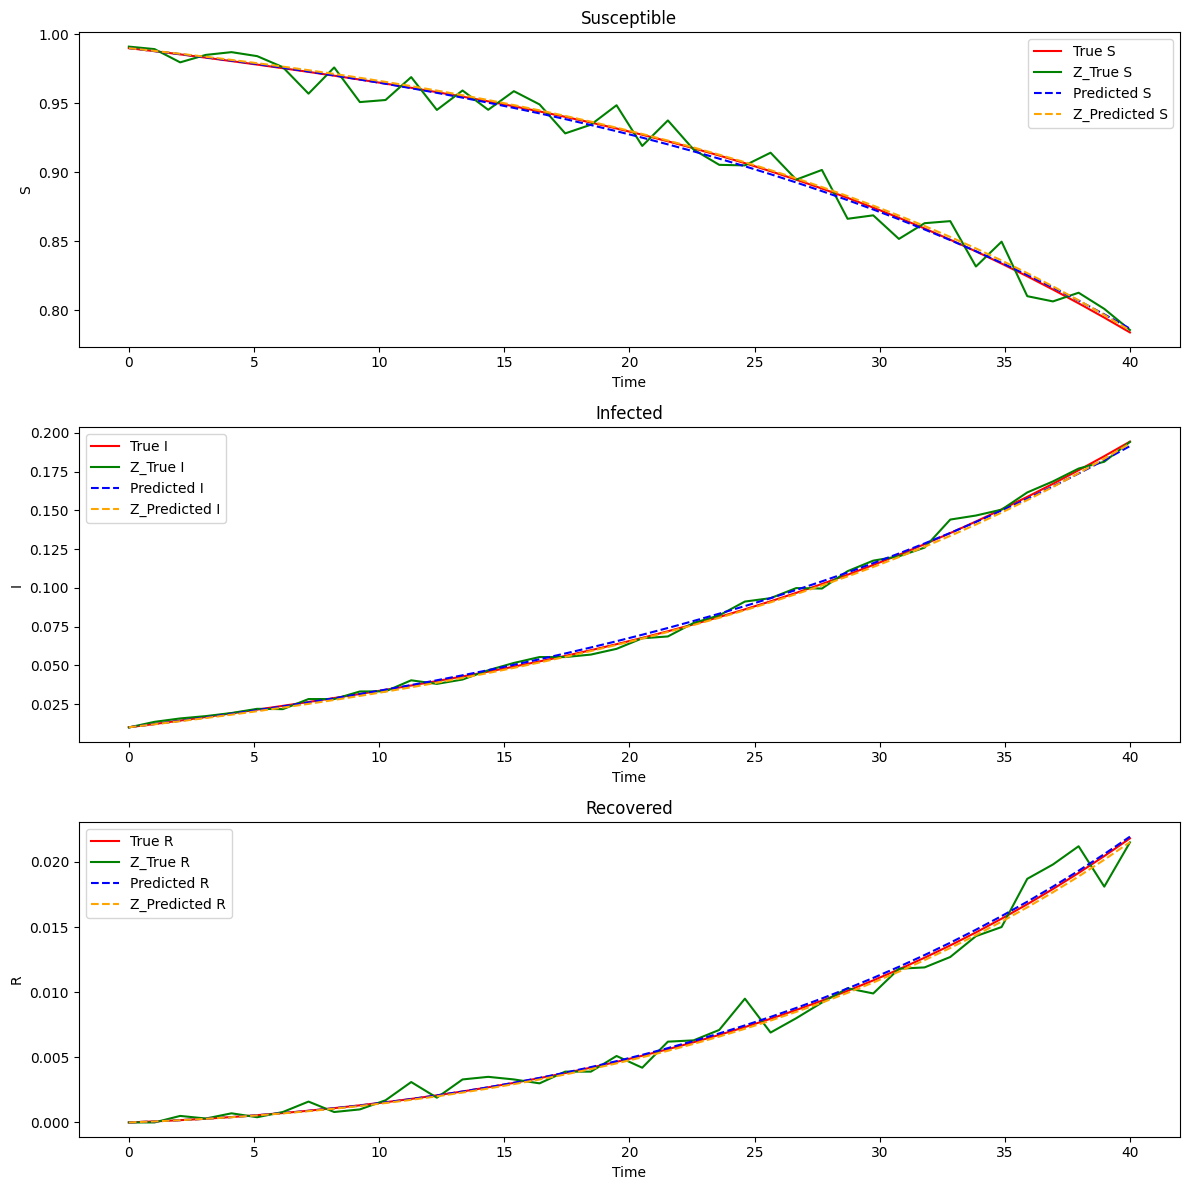

In [200]:
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(t.numpy(), True_y.numpy()[:, 0], '-', label='True S', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 0], '-', label='Z_True S', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 0], '--', label='Predicted S', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 0], '--', label='Z_Predicted S', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(t.numpy(), True_y.numpy()[:, 1], '-', label='True I', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 1], '-', label='Z_True I', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 1], '--', label='Predicted I', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 1], '--', label='Z_Predicted I', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(t.numpy(), True_y.numpy()[:, 2], '-', label='True R', color='red')
plt.plot(t.numpy(), Z_true_y.numpy()[:, 2], '-', label='Z_True R', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 2], '--', label='Predicted R', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 2], '--', label='Z_Predicted R', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')


plt.tight_layout()
plt.show()


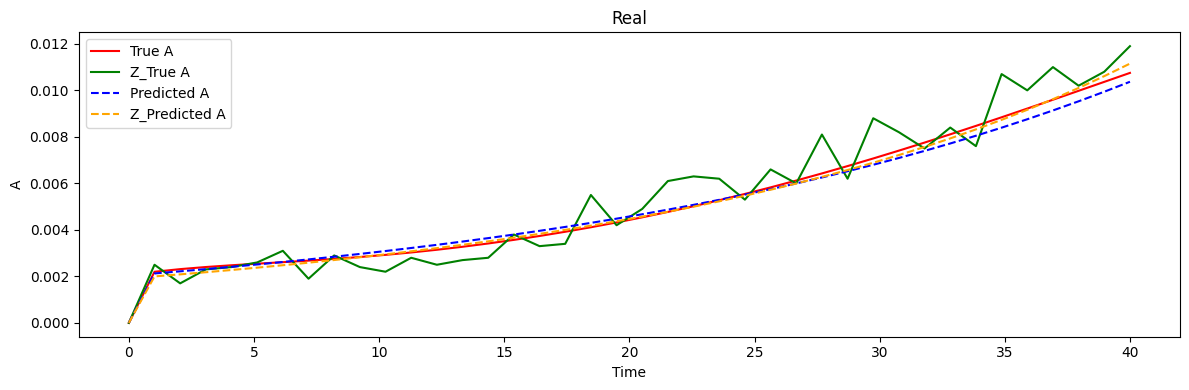

In [201]:
plt.figure(figsize=(12, 4))

plt.plot(t.numpy(), True_y.numpy()[:, 3], '-', label='True A', color='red')
plt.plot(t.numpy(), Z_true_y.detach().numpy()[:, 3], '-', label='Z_True A', color='green')
plt.plot(t.numpy(), pred_y.detach().numpy()[:, 3], '--', label='Predicted A', color='blue')
plt.plot(t.numpy(), Z_pred_y.detach().numpy()[:, 3], '--', label='Z_Predicted A', color='orange')
plt.legend()
plt.xlabel('Time')
plt.ylabel('A')
plt.title('Real')


plt.tight_layout()
plt.show()

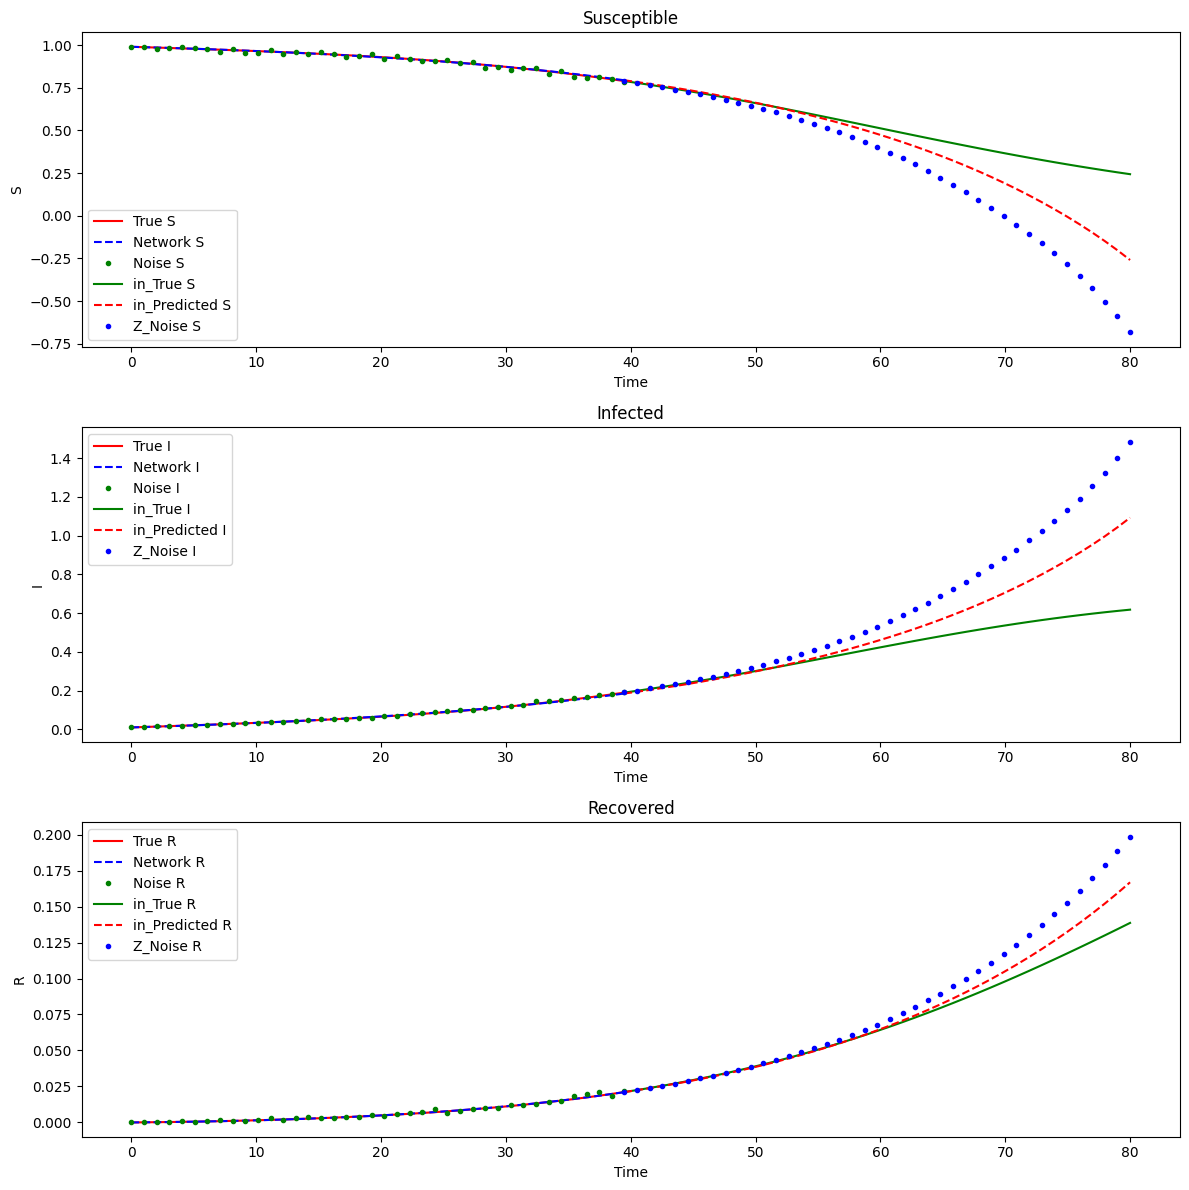

In [202]:
last = int(last)
timeend = int(timeend)
plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 0], '-', label='True S', color='red')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 0], '--', label='Network S', color='blue')
plt.plot(in_t.numpy()[:last], Z_true_y.detach().numpy()[:last, 0], '.', label='Noise S', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 0], '-', label='in_True S', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 0], '--', label='in_Predicted S',color='red')
plt.plot(in_t.numpy()[last-1:timeend], Z_in_pred_y.detach().numpy()[last-1:timeend, 0], '.', label='Z_Noise S', color='blue')
plt.legend()
plt.xlabel('Time')
plt.ylabel('S')
plt.title('Susceptible')

plt.subplot(3, 1, 2)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 1], '-', label='True I', color='red')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 1], '--', label='Network I', color='blue')
plt.plot(in_t.numpy()[:last], Z_true_y.detach().numpy()[:last, 1], '.', label='Noise I', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 1], '-', label='in_True I', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 1], '--', label='in_Predicted I',color='red')
plt.plot(in_t.numpy()[last-1:timeend], Z_in_pred_y.detach().numpy()[last-1:timeend, 1], '.', label='Z_Noise I', color='blue')
plt.legend()
plt.xlabel('Time')
plt.ylabel('I')
plt.title('Infected')

plt.subplot(3, 1, 3)
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 2], '-', label='True R', color='red')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 2], '--', label='Network R', color='blue')
plt.plot(in_t.numpy()[:last], Z_true_y.detach().numpy()[:last, 2], '.', label='Noise R', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 2], '-', label='in_True R', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 2], '--', label='in_Predicted R',color='red')
plt.plot(in_t.numpy()[last-1:timeend], Z_in_pred_y.detach().numpy()[last-1:timeend, 2], '.', label='Z_Noise R', color='blue')
plt.legend()
plt.xlabel('Time')
plt.ylabel('R')
plt.title('Recovered')

plt.tight_layout()
plt.show()

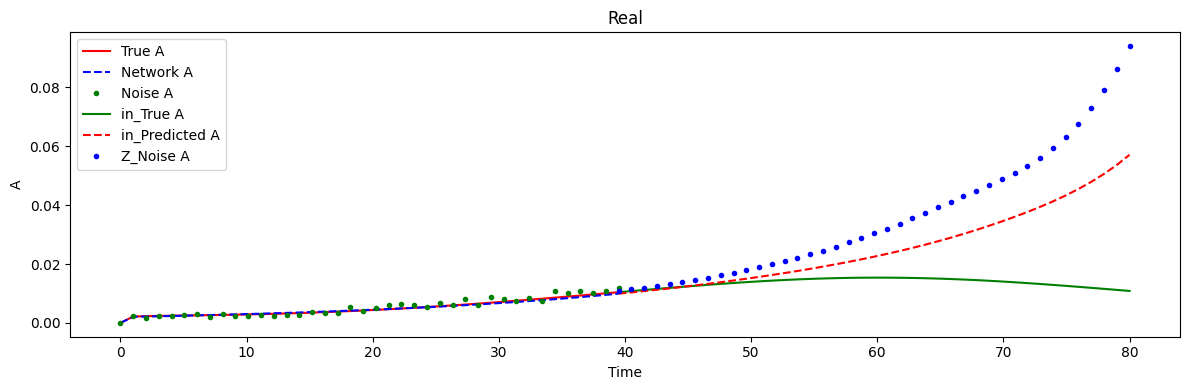

In [203]:
last = int(last)
timeend = int(timeend)
plt.figure(figsize=(12, 4))
plt.plot(in_t.numpy()[:last], in_true_y.numpy()[:last, 3], '-', label='True A', color='red')
plt.plot(in_t.numpy()[:last], in_pred_y.detach().numpy()[:last, 3], '--', label='Network A', color='blue')
plt.plot(in_t.numpy()[:last], Z_true_y.detach().numpy()[:last, 3], '.', label='Noise A', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_true_y.numpy()[last-1:timeend, 3], '-', label='in_True A', color='green')
plt.plot(in_t.numpy()[last-1:timeend], in_pred_y.detach().numpy()[last-1:timeend, 3], '--', label='in_Predicted A',color='red')
plt.plot(in_t.numpy()[last-1:timeend], Z_in_pred_y.detach().numpy()[last-1:timeend, 3], '.', label='Z_Noise A', color='blue')
plt.legend()
plt.xlabel('Time')
plt.ylabel('A')
plt.title('Real')

plt.tight_layout()
plt.show()